# Bagging and Random Forests

In this notebook, we will use the Random Forest algorithm to predict if a cyclist will be in the top 20 in the next race or not.

We start by loading the data and preparing the train set and the test set.

In [11]:
%run ../task4_machine_learning/preprocessing.py
import pandas as pd
from os import path
import os
import numpy as np
import sys

races_final_path = path.join('..','dataset', 'engineered_races.csv')
cyclists_final_path = path.join('..','dataset', 'cyclists_final_enhanced.csv')


cyclists_data = pd.read_csv(cyclists_final_path)
races_data = pd.read_csv(races_final_path)
X_train,y_train,X_test,y_test,columns_to_keep=get_train_test_data()

So the data is set up however we need to evaluate training data to see which approach works best.

In [12]:
X_train.shape

(554459, 10)

In [13]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

Data is a lot using a k-fold is best but very time consuming, a holdout method is more practical in this case.

In [34]:
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold , GridSearchCV, train_test_split,ParameterGrid
from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED=42
NUM_FOLDS=5

#heavy imbalance in the dataset for class 1, a test using heavily imbalanced class weights is due

hyper_params={
    'n_estimators': [50, 100, 200,500],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 2, 3,4,5],
    'max_depth': [10, 20,30, None],
    'min_samples_split': [2, 5, 10,20],
    'min_samples_leaf': [1, 3, 5,10],
    'bootstrap': [True],
    'class_weight': ['balanced']# heavy class imbalance -> penalize misclassification on minority class
}

# hyper params grid
grid_params=ParameterGrid(hyper_params)

X_train_set, X_val_set, Y_train_set, Y_val_set = train_test_split(
    X_train,y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_SEED,
    shuffle=True
)

params_tested=list()

for comb in grid_params:
    rfc=RandomForestClassifier(**comb,n_jobs=-1)
    rfc=rfc.fit(X_train_set,Y_train_set)

    Y_pred_train_set=rfc.predict(X_train_set)
    Y_pred_val_set=rfc.predict(X_val_set)
    train_f_score=f1_score(Y_train_set,Y_pred_train_set)
    val_f_score=f1_score(Y_val_set,Y_pred_val_set)
    new_comb=comb
    new_comb|={
        'train_f1_score':train_f_score,
        'val_f1_score':val_f_score,
    }
    print(comb)
    report_scores(Y_val_set,Y_pred_val_set)
    params_tested.append(new_comb)

params_df=pd.DataFrame(params_tested)


params_df.sort_values(by='val_f1_score')

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'train_f1_score': 0.4522242293961478, 'val_f1_score': 0.4344229486324216}
              precision    recall  f1-score   support

           0       0.90      0.76      0.82     92129
           1       0.34      0.61      0.43     18763

    accuracy                           0.73    110892
   macro avg       0.62      0.68      0.63    110892
weighted avg       0.81      0.73      0.76    110892

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'train_f1_score': 0.4558155208935105, 'val_f1_score': 0.43928413525307086}
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     92129
           1       0.34      0.61      0.44     18763

    a

KeyboardInterrupt: 

In [7]:
import json

params_df=pd.DataFrame(params_tested)


params_df.sort_values(by='val_f1_score',ascending=False)
#save results
params_df.to_json('params_rf/test_f1_binary.json')

In [35]:
import pandas as pd
from os import path
import numpy as np

top20_params=pd.read_json('params_rf/test_f1_binary.json').sort_values(by='val_f1_score',ascending=False)[:20]
top20_params

,bootstrap,class_weight,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,train_f1_score,val_f1_score
2447,True,balanced,entropy,NaN,4,1,20,500,0.801598,0.560977
2142,True,balanced,entropy,30.0,4,3,20,200,0.778936,0.560361
2383,True,balanced,entropy,NaN,3,1,20,500,0.791579,0.560295
2063,True,balanced,entropy,30.0,3,1,20,500,0.785548,0.560143
1103,True,balanced,gini,NaN,3,1,20,500,0.779968,0.560074
2143,True,balanced,entropy,30.0,4,3,20,500,0.779229,0.560056
1167,True,balanced,gini,NaN,4,1,20,500,0.787674,0.560018
2207,True,balanced,entropy,30.0,5,3,20,500,0.788677,0.560012
2399,True,balanced,entropy,NaN,3,3,20,500,0.773469,0.559996
2062,True,balanced,entropy,30.0,3,1,20,200,0.784191,0.559960


- The best-performing criterion appears to be **`entropy`**, which makes sense given the task. We can infer that the distribution is imbalanced (obviously), and that features are likely less redundant.
- The **`max_depth`** parameter is often set to either **`None`** (unlimited depth) or **30**. This suggests that the model could benefit from regularization by limiting the maximum depth to avoid overly complex models that might overfit.
- The **`min_samples_split`** value indicates that patterns in the dataset are complex, using less samples. This may suggest a difficult task, and using smaller values helps capture these complex patterns but could also be overfitting.
- Given there are **8 features**, the **`max_features`** value is quite high, which could lead to highly correlated trees, thus weakening the uncorrelation principle mentioned in section 7.11 [here](https://www.deeplearningbook.org/contents/regularization.html). Lower values for this parameter might improve the model's performance by reducing the correlation between trees.
- The **`min_samples_leaf`** parameter favors lower values, indicating that the model tends to overfit. A higher value would help with regularization by forcing each leaf node to contain more samples.
- The **`n_estimators`** is expected to be high, given the dataset's size. The best-performing model has **500 estimators**. However, using too many estimators can indicate overfitting for very complex models. Following Occam's Razor, we should prioritize models with fewer estimators that achieve similar performance on the validation set.

Among the models with the best validation F1 scores shown in the table above, the second model is an "outlier." It has lower training performance but achieves a comparable validation performance, indicating better generalization. This model, with less complexity, is the one we will use for the test set.

Building on this model's results, it could be valuable to test more hyperparameters, starting from the ones found using a gridsearch.

In [51]:
final_params=top20_params.iloc[1]
print("final parameters",final_params)
rfc=RandomForestClassifier(
    bootstrap=final_params['bootstrap'],
    class_weight=final_params['class_weight'],
    criterion=final_params['criterion'],
    max_depth=int(final_params['max_depth']),
    max_features=int(final_params['max_features']),
    min_samples_leaf=int(final_params['min_samples_leaf']),
    min_samples_split=int(final_params['min_samples_split']),
    n_estimators=int(final_params['n_estimators']),
)

final parameters bootstrap                True
class_weight         balanced
criterion             entropy
max_depth                30.0
max_features                4
min_samples_leaf            3
min_samples_split          20
n_estimators              200
train_f1_score       0.778936
val_f1_score         0.560361
Name: 2142, dtype: object


In [53]:
rfc=rfc.fit(X_train_set,Y_train_set)
Y_pred_train_set=rfc.predict(X_train_set)
Y_pred_val_set=rfc.predict(X_val_set)
train_f_score=f1_score(Y_train_set,Y_pred_train_set)
val_f_score=f1_score(Y_val_set,Y_pred_val_set)

a first idea to see how the model generalizes is to plot the roc curve

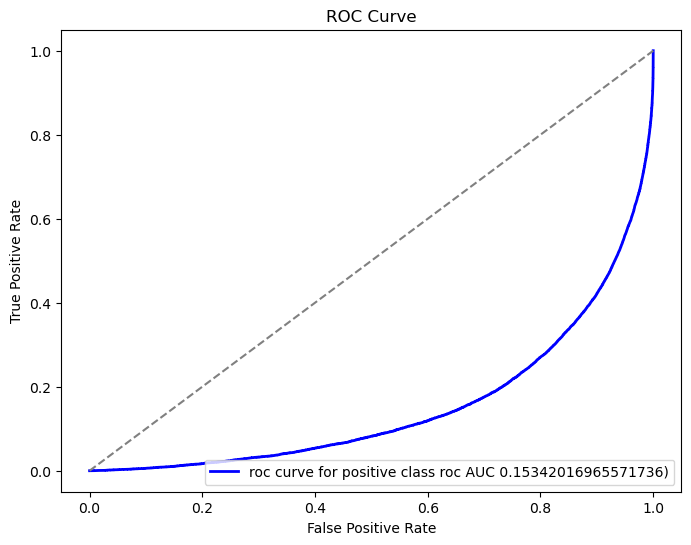

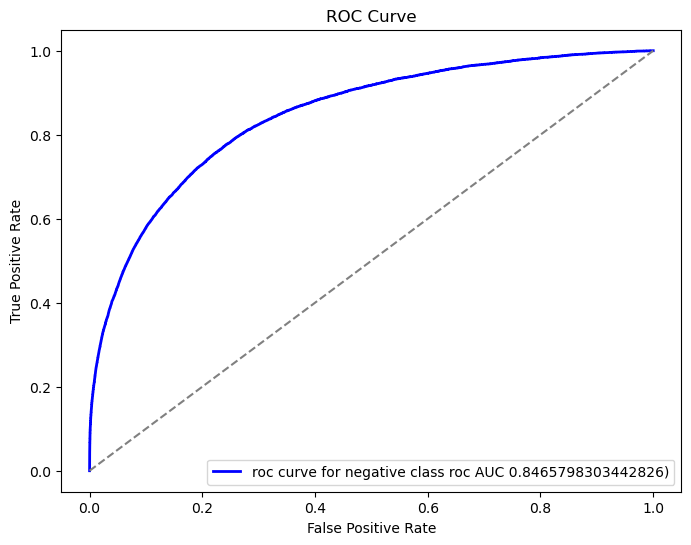

In [57]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

val_y_proba_pos=rfc.predict_proba(X_val_set)[:,0]
val_y_proba_neg=rfc.predict_proba(X_val_set)[:,1]

# Calculate ROC curve
fpr_pos, tpr_pos, thresholds_pos = roc_curve(Y_val_set, val_y_proba_pos)
fpr_neg, tpr_neg, thresholds_neg = roc_curve(Y_val_set, val_y_proba_neg)

# Calculate AUC (Area Under the Curve)
roc_auc_pos = auc(fpr_pos, tpr_pos)
roc_auc_neg = auc(fpr_neg, tpr_neg)


def plot_roc_curve(title,fpr,tpr,roc_auc):
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'{title} roc AUC {roc_auc})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve("roc curve for positive class",fpr_pos,tpr_pos,roc_auc_pos)
plot_roc_curve("roc curve for negative class",fpr_neg,tpr_neg,roc_auc_neg)


Another nice idea would be to plot the confusion matrix for the classes.

In [38]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [ ]:
from sklearn.metrics import confusion_matrix
#compute the performance of the model
report_scores(Y_val_set,Y_pred_val_set)
print("binary f1 score",val_f_score)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90     92129
           1       0.52      0.60      0.56     18763

    accuracy                           0.84    110892
   macro avg       0.72      0.74      0.73    110892
weighted avg       0.85      0.84      0.84    110892

binary f1 score 0.5580747119285234


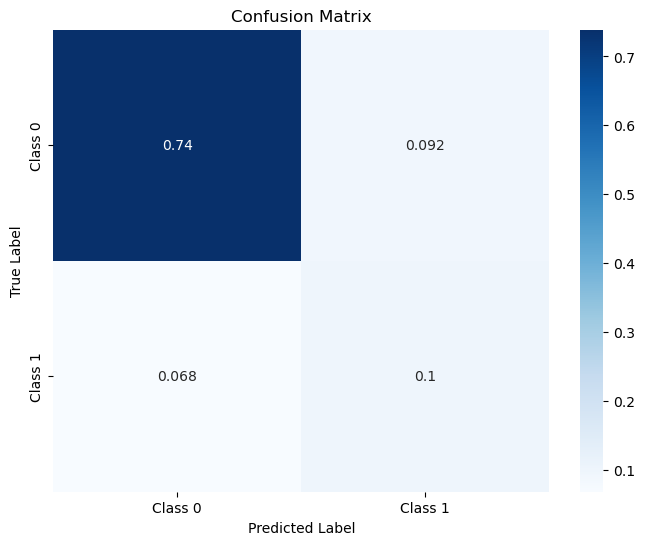

In [49]:
import seaborn as sns

cm = confusion_matrix(Y_val_set, Y_pred_val_set,normalize='all')

def plot_conf_matrix(cm):
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_conf_matrix(cm)

# Conclusions

Ok after a thorough selection and testing we can see that the model is still affected by the heavy imbalance in the dataset it manages to get correct values on the majority class but fails on the minority class which means that it doesn't get really good performances, this sounds reasonable given that the bagging strategy manages to get better results when we have highly uncorrelated models which is not the case as indicated from the high number of max_features selected by the grid search. 
Further experiments could be done by further tuning the parameters we found in this trials,also techiniques like oversampling/undersampling could lead to better results, another interisting idea could be to included highly dimensional features in the dataset and make so that models using the same number of max features we found are more uncorrelated and this should improve generalization.